In [81]:
import fiona
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from time import time
from tqdm import tqdm
import xarray as xr
import torch
import torch.nn as nn
from torch import optim

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

seed = 1234
np.random.seed(seed)

## 1. Read Xarray Files


In [82]:
def get_filenames(directory):
    filenames = sorted(os.listdir(directory))
    return [f for f in filenames if f.endswith(".nc")]


def get_path(directory, filename):
    return os.path.join(directory, filename)


def get_basename(path):
    return os.path.basename(path)


def get_month_year(file_name, dtype="ppt"):
    """Get month and year from file name"""
    if dtype == "ppt":
        time = pd.Timestamp("-".join(file_name.split(".")[0].split("_")[1:]))
        month, year = time.month, time.year
    elif dtype == "sst":
        year, month = file_name.split(".")[-2][-6:-2], file_name.split(".")[-2][-2:]
        month, year = int(month), int(year)
    else:
        print(f"dtype {dtype} not implemented. Use ppt or sst.")
        month, year = None, None
    return month, year


def read_xr(path, dtype="ppt"):
    """Read xarray file"""
    file_data = xr.load_dataset(path, engine="netcdf4")
    file_name = get_basename(path)
    month, year = get_month_year(file_name, dtype)
    xr_data = [file_name, year, month]

    if dtype == "ppt":
        file_data = file_data.rename_vars(
            {list(file_data.keys())[1]: "ppt", "longitude": "lon", "latitude": "lat"}
        )

        # Coarsen data to reduce resolution
        file_data = file_data.coarsen(latitude=4, longitude=4, boundary="trim").mean()
        #         file_data = file_data.sel(longitude=slice(-300, -100))

        ##Slice for west coast
        file_data = file_data.sel(longitude=slice(0, 150))

        xr_data.append(file_data.ppt.values)
        columns = list("FYMD")
        columns[-1] = "ppt"

    elif dtype == "sst":
        # Coarsen data to reduce resolution
        #         file_data = file_data.coarsen(lat = 4, lon = 4, boundary = "trim").mean()

        ##Slice for west coast
        #         file_data = file_data.sel(lon=slice(100, 400))

        xr_data.extend([file_data.sst.values, file_data.ssta.values])
        columns = list("FYMDA")
        columns[-2], columns[-1] = "sst", "ssta"

    else:
        print(f"dtype {dtype} not implemented. Use ppt or sst.")

    longitude, latitude = file_data.lon.values, file_data.lat.values
    return xr_data, longitude, latitude, columns


def load_data(directory, dtype="ppt"):
    """Load directory files in a pandas dataframe"""
    filenames = get_filenames(directory)
    data_info_list = []
    for i, file_name in tqdm(enumerate(filenames)):
        path = get_path(directory, file_name)
        xr_data, longitude, latitude, columns = read_xr(path, dtype)
        data_info_list.append(xr_data)
    df = pd.DataFrame([p for p in data_info_list], columns=columns)
    return df, latitude, longitude

#### `Change ppt_directory and sst_directory based on your directories`


In [83]:
ppt_directory = "data/ppt-nc-1895-2020"
sst_directory = "data/ERSST"

In [84]:
### Load ppt data
ppt_df, lat, lon = load_data(ppt_directory, dtype="ppt")

759it [00:08, 87.01it/s]


### PPT Levels in different U.S. States


In [85]:
def show_states(west_coast=True, state_file="States/cb_2018_us_state_20m.shp"):
    shape = fiona.open(state_file)
    for s in shape:
        pts = s["geometry"]["coordinates"]
        for p in pts:
            state = np.array(p).squeeze()
            if state[:, 1].min() < 50 and state[:, 1].min() > 22:
                if not west_coast:
                    plt.plot(state[:, 0], state[:, 1], color="black")
                elif np.max(state[:, 0]) < -100:  # plot only west coast
                    plt.plot(state[:, 0], state[:, 1], color="black")

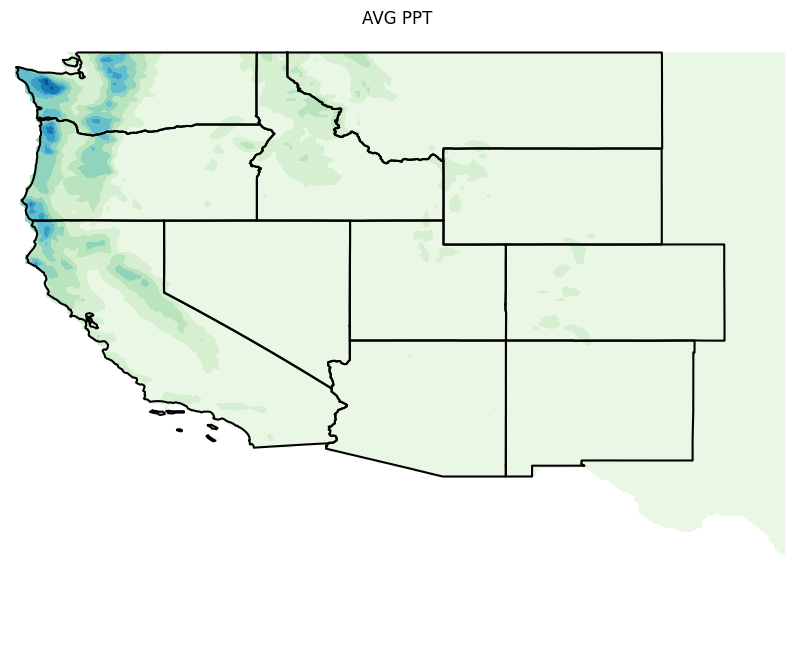

In [86]:
avg_ppt = ppt_df["ppt"].mean()

plt.figure(figsize=(10, 8))
xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, avg_ppt, cmap="GnBu")
show_states()
plt.axis("off")
plt.title("AVG PPT")
plt.show()
plt.close()

In [87]:
### Load sst data
sst_df, _, _ = load_data(sst_directory, dtype="sst")
sst_df

1644it [00:05, 300.30it/s]


,F,Y,M,sst,ssta
0,ersst.v5.188001.nc,1880,1,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1,ersst.v5.188002.nc,1880,2,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
2,ersst.v5.188003.nc,1880,3,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
3,ersst.v5.188004.nc,1880,4,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
4,ersst.v5.188005.nc,1880,5,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
...,...,...,...,...,...
1639,ersst.v5.201608.nc,2016,8,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1640,ersst.v5.201609.nc,2016,9,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1641,ersst.v5.201610.nc,2016,10,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1642,ersst.v5.201611.nc,2016,11,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...


### SST Levels


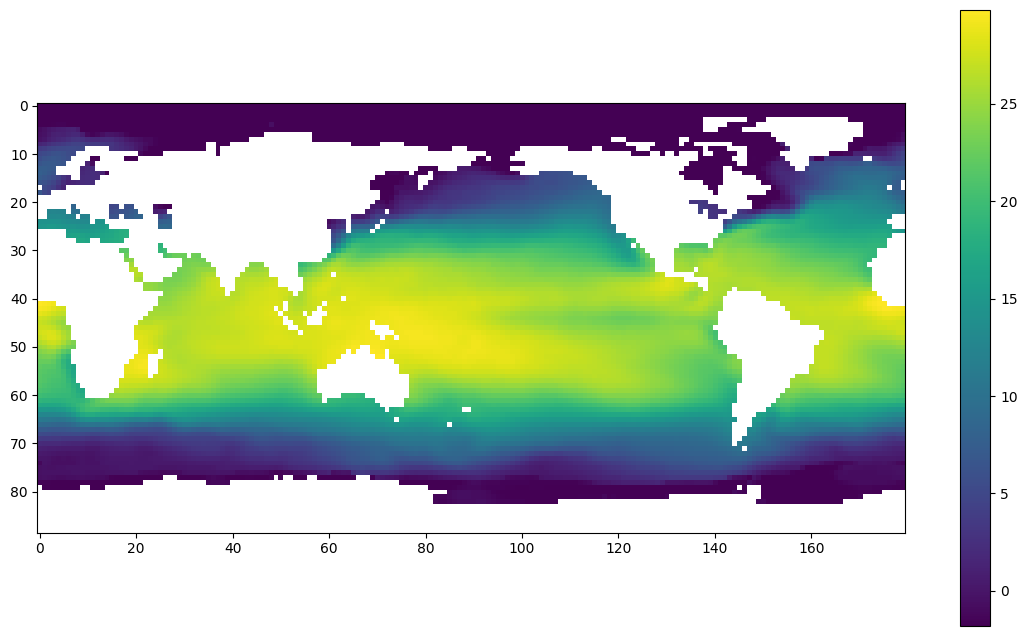

(1644,)

In [88]:
plt.figure(figsize=(14, 8))
sst_example = sst_df["sst"].iloc[0]
plt.imshow(np.flipud(sst_example.reshape(sst_example.shape[-2], sst_example.shape[-1])))
plt.colorbar()
plt.show()
sst_df["sst"].shape

In [89]:
## Check shapes of ppt and sst
sst_df["sst"].iloc[0].shape, ppt_df["ppt"].iloc[0].shape

((1, 1, 89, 180), (155, 150))

In [90]:
# get rainfall month and year
rain_row = ppt_df.iloc[0]
m, y = rain_row["M"], rain_row["Y"]

# get sst month and year
sst_row = sst_df[(sst_df["M"] == m) & (sst_df["Y"] == y)]  # bitmask filters for month and year
index_position = sst_row.index[0]  # index returns Index object, so we need to get the first element

# if index_position < 24:
#     # do something, though this should never happen cuz sst starts far earlier

prev24 = sst_df.iloc[index_position - 24 : index_position]

In [91]:
import pandas as pd

# Sample DataFrame
data = {
    "month": [1, 5, 7, 5, 12],
    "year": [2020, 2021, 2021, 2022, 2020],
    "data": ["A", "B", "C", "D", "E"],  # Additional data column for illustration
}
df = pd.DataFrame(data)

# Your target month and year
target_month = 5
target_year = 2021

# Create a boolean mask to filter the DataFrame
mask = (df["month"] == target_month) & (df["year"] == target_year)

# Apply the mask to the DataFrame
filtered_df = df[mask]

# Display the filtered DataFrame
print(filtered_df)

   month  year data
1      5  2021    B


## 2. Combine SST and PPT


In [92]:
df = sst_df.merge(ppt_df, on=["Y", "M"], suffixes=("_sst", "_ppt"), how="inner")

## 3. Add Temporal Features


In [93]:
def add_time(df):
    """Add Time Column"""
    min_year = np.min(df["Y"])
    df["T"] = (df["Y"] - min_year) * 12 + df["M"]
    return df


def add_season(df):
    """adds Season Column (0 for months 1,2,3 and 1 for months 10,11,12)"""
    df["season"] = ((df["M"] - 1) // 4).astype(bool).astype(int)
    return df


df = add_season(add_time(df))
df.to_csv("data/df.csv", index=False)

### ppt has data for only months 1,2,3,10,11,12. While sst has all months.


## 4. Add Clusters


In [94]:
clusters = np.load("clusters.npy")

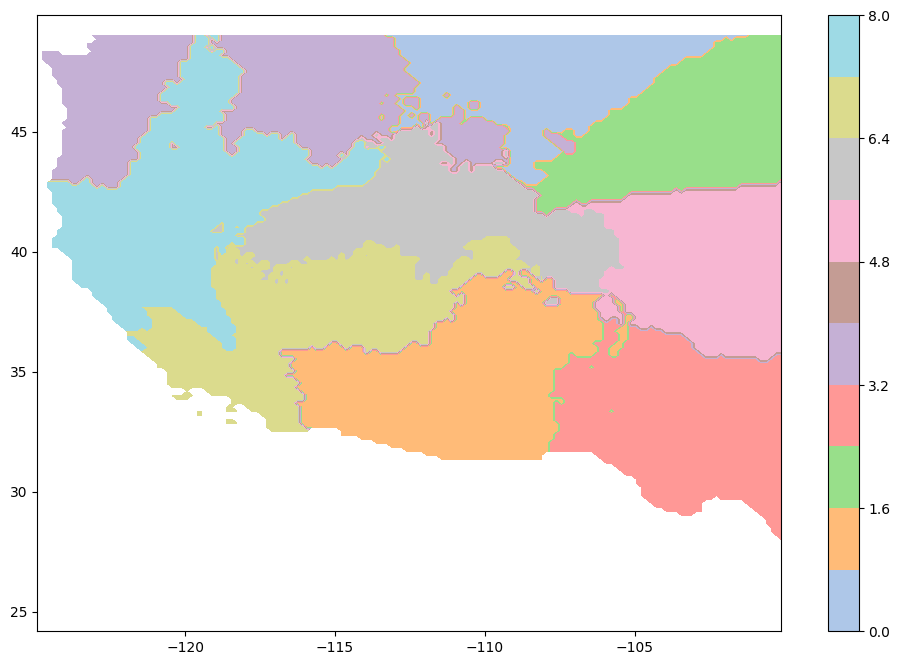

np.unique(clusters):  [ 0.  1.  2.  3.  4.  5.  6.  7.  8. nan]


In [95]:
plt.figure(figsize=(12, 8))
xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, clusters, levels=10, cmap="tab20")
plt.colorbar()
plt.show()
print("np.unique(clusters): ", np.unique(clusters))

In [96]:
def average_clusters(image, cluster_array, return_image=True):
    """Average the values of each cluster in the image"""
    unique_clusters = np.unique(cluster_array)  # Find unique cluster labels

    if return_image:
        # Initialize an array to store the average values
        averaged_image = np.zeros_like(image, dtype=float)
    else:
        cluster_averages = []

    for cluster_label in unique_clusters:
        # Mask the original image with the current cluster label
        masked_image = np.where(cluster_array == cluster_label, image, 0)

        # Calculate the average value for the current cluster
        cluster_size = np.sum(cluster_array == cluster_label)
        cluster_average = np.sum(masked_image) / cluster_size

        if return_image:
            # Replace pixels in the averaged image with the cluster average
            averaged_image += np.where(
                cluster_array == cluster_label, cluster_average, 0
            )
        else:
            cluster_averages.append(cluster_average)

    return averaged_image if return_image else np.array(cluster_averages)


avg_clusters = average_clusters(df.iloc[0].ppt, clusters)
avg_clusters

/var/folders/j3/ll6yjvb96yjb1gn7mk4x45zh0000gn/T/ipykernel_45155/790362116.py:17: RuntimeWarning: invalid value encountered in divide
  cluster_average = np.sum(masked_image) / cluster_size


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

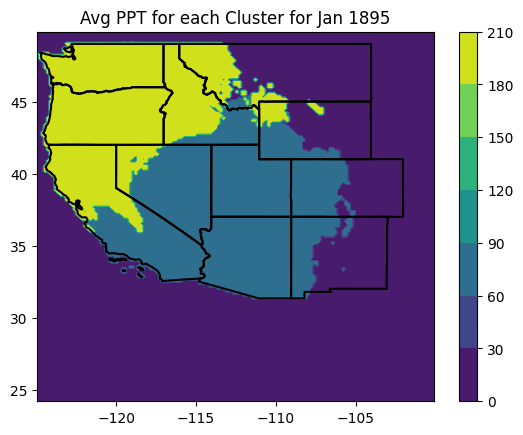

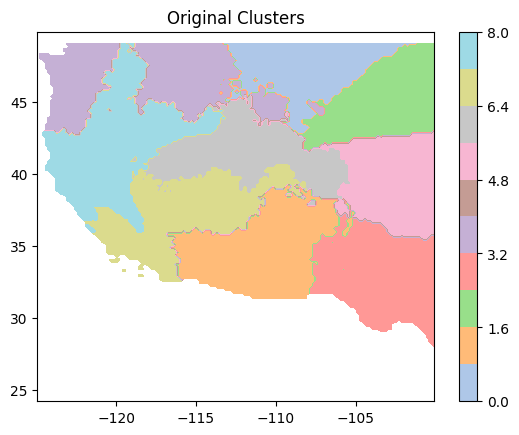

In [97]:
plt.contourf(xx, yy, avg_clusters)
plt.colorbar()
show_states()
plt.title("Avg PPT for each Cluster for Jan 1895")
plt.show()

xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, clusters, levels=10, cmap="tab20")
plt.colorbar()
plt.title("Original Clusters")
plt.show()

In [98]:
df["ppt_cluster"] = df["ppt"].apply(lambda x: average_clusters(x, clusters))
df["ppt_cluster_vector"] = df["ppt"].apply(
    lambda x: average_clusters(x, clusters, return_image=False)[:-1]
)

/var/folders/j3/ll6yjvb96yjb1gn7mk4x45zh0000gn/T/ipykernel_45155/790362116.py:17: RuntimeWarning: invalid value encountered in divide
  cluster_average = np.sum(masked_image) / cluster_size
/var/folders/j3/ll6yjvb96yjb1gn7mk4x45zh0000gn/T/ipykernel_45155/790362116.py:17: RuntimeWarning: invalid value encountered in divide
  cluster_average = np.sum(masked_image) / cluster_size


## 5. Add Quantiles


In [99]:
def get_quantiles(df, cluster=True):

    vector = df.ppt_cluster_vector if cluster else df.ppt

    ppt_vector = np.stack(vector.apply(lambda x: x.reshape(-1))).T
    q1 = np.quantile(ppt_vector, 0.25, axis=1, keepdims=True).flatten()
    q2 = np.quantile(ppt_vector, 0.5, axis=1, keepdims=True).flatten()
    q3 = np.quantile(ppt_vector, 0.75, axis=1, keepdims=True).flatten()
    return q1, q2, q3


q1, q2, q3 = get_quantiles(df)
q1

array([ 9.5338221 , 12.17312131,  9.24412442,  7.47316639, 94.40965887,
        8.27551748, 25.58297759, 13.8765325 , 42.52929087])

In [100]:
def get_quantized(x, q1, q2, q3):
    output = np.zeros_like(x)
    output[x <= q1] = 1
    q2_arr = np.array(x > q1) * np.array(x <= q2)
    q3_arr = np.array(x > q2) * np.array(x <= q3)
    output[q2_arr] = 2
    output[q3_arr] = 3
    output[x > q3] = 4
    return output

In [101]:
df["ppt_cluster_vector_quantized"] = df["ppt_cluster_vector"].apply(
    lambda x: get_quantized(x, q1, q2, q3)
)
df[["T", "M", "ppt_cluster_vector_quantized"]]

,T,M,ppt_cluster_vector_quantized
0,1,1,"[4.0, 4.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 4.0]"
1,2,2,"[3.0, 3.0, 3.0, 4.0, 1.0, 4.0, 2.0, 3.0, 2.0]"
2,3,3,"[2.0, 1.0, 3.0, 1.0, 1.0, 2.0, 3.0, 3.0, 2.0]"
3,10,10,"[1.0, 3.0, 1.0, 4.0, 1.0, 3.0, 1.0, 1.0, 1.0]"
4,11,11,"[4.0, 4.0, 4.0, 4.0, 2.0, 3.0, 3.0, 2.0, 1.0]"
...,...,...,...
727,1454,2,"[1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 1.0, 2.0, 1.0]"
728,1455,3,"[3.0, 1.0, 4.0, 2.0, 4.0, 4.0, 4.0, 3.0, 4.0]"
729,1462,10,"[4.0, 1.0, 4.0, 2.0, 4.0, 2.0, 4.0, 2.0, 4.0]"
730,1463,11,"[2.0, 3.0, 3.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0]"


## Organizing Data into y_labels and x_input

Want to create a dataframe of sea surface temperature input for each cluster precipitation estimation (1, 2, 3, or 4).
The input data should be 24 months worth of sea surface temperature data. This data is stored in a quadruple vector.
For each a ppt_cluster_vector quantity, grab the last 24 months of "sst" quadruple vector data information.
to test.


### Organizing Y Labels


In [102]:
y_labels = df.loc[:,["Y", "M", "ppt_cluster_vector_quantized"]]
y_labels = y_labels.rename(columns={"M": "month", "Y": "year"})
y_labels["date"] = pd.to_datetime(y_labels[["month","year"]].assign(day=1))
y_labels["date"] = y_labels['date']

y_labels.drop(["month"], axis=1, inplace=True)
y_labels.drop(["year"], axis=1, inplace=True)
y_labels.set_index("date", inplace=True)
y_labels

,ppt_cluster_vector_quantized
date,
1895-01-01,"[4.0, 4.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 4.0]"
1895-02-01,"[3.0, 3.0, 3.0, 4.0, 1.0, 4.0, 2.0, 3.0, 2.0]"
1895-03-01,"[2.0, 1.0, 3.0, 1.0, 1.0, 2.0, 3.0, 3.0, 2.0]"
1895-10-01,"[1.0, 3.0, 1.0, 4.0, 1.0, 3.0, 1.0, 1.0, 1.0]"
1895-11-01,"[4.0, 4.0, 4.0, 4.0, 2.0, 3.0, 3.0, 2.0, 1.0]"
...,...
2016-02-01,"[1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 1.0, 2.0, 1.0]"
2016-03-01,"[3.0, 1.0, 4.0, 2.0, 4.0, 4.0, 4.0, 3.0, 4.0]"
2016-10-01,"[4.0, 1.0, 4.0, 2.0, 4.0, 2.0, 4.0, 2.0, 4.0]"


In [103]:
sst_condensed = sst_df.loc[:,["Y", "M", "sst"]]
sst_condensed = sst_condensed.rename(columns={"M": "month", "Y": "year"})
sst_condensed["date"] = pd.to_datetime(sst_condensed[["month","year"]].assign(day=1))
sst_condensed["date"] = sst_condensed['date']

sst_condensed.drop(["month"], axis=1, inplace=True)
sst_condensed.drop(["year"], axis=1, inplace=True)
sst_condensed.set_index("date", inplace=True)
sst_condensed

,sst
date,
1880-01-01,[[[[nan nan nan nan nan nan nan nan nan nan na...
1880-02-01,[[[[nan nan nan nan nan nan nan nan nan nan na...
1880-03-01,[[[[nan nan nan nan nan nan nan nan nan nan na...
1880-04-01,[[[[nan nan nan nan nan nan nan nan nan nan na...
1880-05-01,[[[[nan nan nan nan nan nan nan nan nan nan na...
...,...
2016-08-01,[[[[nan nan nan nan nan nan nan nan nan nan na...
2016-09-01,[[[[nan nan nan nan nan nan nan nan nan nan na...
2016-10-01,[[[[nan nan nan nan nan nan nan nan nan nan na...


In [104]:
x_input_rows = []
for date in y_labels.index:
    start_date = date - pd.DateOffset(months=23)
    end_date = date
    
    sst_in_range = np.array(sst_condensed.loc[start_date:end_date, 'sst'].tolist()) # shape here is (24, 1, 1, 89, 180)
    sst_in_range = sst_in_range.flatten() #1 x 384480
    sst_in_range = sst_in_range[~np.isnan(sst_in_range)] # 263712
    
    x_input_rows.append({'start date': start_date, 'end date' : end_date, 'sst rows': sst_in_range})

x_input = pd.DataFrame(x_input_rows)
x_input["start date"] = x_input["start date"].dt.to_period('M')
x_input["end date"] = x_input["end date"].dt.to_period('M')
sst_data = np.array([xi.tolist() for xi in np.array(x_input[:]["sst rows"])])

In [105]:
ppt_data = np.array(y_labels["ppt_cluster_vector_quantized"])
ppt_cluster1 = np.array([x[0] for x in ppt_data])
ppt_cluster2 = np.array([x[1] for x in ppt_data])
ppt_cluster3 = np.array([x[2] for x in ppt_data])
ppt_cluster4 = np.array([x[3] for x in ppt_data])
ppt_cluster5 = np.array([x[4] for x in ppt_data])
ppt_cluster6 = np.array([x[5] for x in ppt_data])
ppt_cluster7 = np.array([x[6] for x in ppt_data])
ppt_cluster8 = np.array([x[7] for x in ppt_data])
ppt_cluster9 = np.array([x[8] for x in ppt_data])

## Training a Random Forest

We now have our nine label clusters and our input rows as well (which contain the flatten sea surface temperature data across the globe, excluding land coordinates). We'd like to train a random forest model on these as the first iteration of trying to fit a model.


In [106]:
X_train, X_test, y_train, y_test = train_test_split(sst_data, ppt_cluster9, test_size=0.1, random_state=4)

rf = RandomForestClassifier(max_depth=1, min_samples_leaf=100, n_estimators=25) # since there are only 4 possible outputs, we use a Classifier

rf.fit(X_train, y_train)
print(X_train.shape[1])
print(y_train.shape)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

263712
(658,)
Accuracy:  0.44594594594594594


## Testing Hyperparameters

Use GridSearchCV library to test different values for different parameters


In [107]:
# params = {
#     'max_depth': [1,2,3,5,10,20, 50, 100, 150, 200, 500, None],
#     'min_samples_leaf': [1, 5, 10, 20, 50, 100, 200, 500],
#     'n_estimators': [10,25,30,50,100,200]
# }

# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator=rf,
#                            param_grid=params,
#                            cv = 4,
#                            n_jobs=-1, verbose=1, scoring="accuracy")



# grid_search.fit(list(X_train), y_train)

In [108]:
# best_score = grid_search.best
# best_esty = grid_search.best_estimator_
# print(f"best accuracy from tuning test: {best_score}")
# print(f"best estimators to use from tuning: {best_esty}")_score_

## Trying Neural Network

Creating and training a logistic regression model


#### Model


In [109]:
class Dropout(nn.Module):
    def __init__(self, rate=0.05):
        # Rate specifies the dropout rate (r)
        super().__init__()
        self.rate = rate

    def forward(self, x):
        if self.training:
            mask = torch.rand(x.shape) > self.rate
            return torch.mul(x, mask.float())
        else:
            return (1 - self.rate) * x

class LinearKaiming(nn.Module):
    def __init__(self, in_dimensions, out_dimensions):
        super().__init__()
        root_d = np.sqrt(in_dimensions)
        self.weights = nn.Parameter(torch.randn(in_dimensions, out_dimensions) / root_d)
        self.bias = nn.Parameter(torch.zeros(out_dimensions))

    def forward(self, x):
        return torch.matmul(x, self.weights) + self.bias

class RainPrediction(nn.Module):
    def __init__(self, num_regions, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            Dropout(),
            LinearKaiming(num_regions, 20),
            nn.ReLU(),
            Dropout(),
            LinearKaiming(20, 20),
            nn.ReLU(),
            Dropout(),
            LinearKaiming(20, 20),
            nn.ReLU(),
            Dropout(),
            LinearKaiming(20, 20),
            nn.ReLU(),
            Dropout(),
            LinearKaiming(20, num_classes),
        )

    def forward(self, x):
        return self.model(x)
    

#### Training


In [116]:
def gradient_descent(model, loss_func, x, y, xvalid, yvalid, lr=0.1, steps=5000):
    optimizer = optim.SGD(model.parameters(), lr)

    losses = []
    valid_losses = []
    for _ in tqdm(range(steps)):
        model.train()
        loss = loss_func(model(x), y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        model.eval()
        valid_loss = loss_func(model(xvalid), yvalid)
        losses.append(loss.detach().numpy())
        valid_losses.append(valid_loss.detach().numpy())

    print(f"Final training loss: {losses[-1]}")

    return losses, valid_losses

lr = 0.001
loss_func = nn.CrossEntropyLoss()
model = RainPrediction(X_train.shape[1], 5)
X_train, X_test = torch.tensor(X_train, dtype=torch.long),torch.tensor(X_test, dtype=torch.long)
y_train, y_test = torch.tensor(y_train, dtype=torch.long),torch.tensor(y_test, dtype=torch.long)

losses, valid_losses = gradient_descent(
    model, loss_func, X_train, y_train, X_test, y_test, lr=lr, steps=5000
)

/var/folders/j3/ll6yjvb96yjb1gn7mk4x45zh0000gn/T/ipykernel_45155/4068764973.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, X_test = torch.tensor(X_train, dtype=torch.long),torch.tensor(X_test, dtype=torch.long)
/var/folders/j3/ll6yjvb96yjb1gn7mk4x45zh0000gn/T/ipykernel_45155/4068764973.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train, y_test = torch.tensor(y_train, dtype=torch.long),torch.tensor(y_test, dtype=torch.long)
  9%|▊         | 437/5000 [06:07<1:07:41,  1.12it/s]